In [12]:
import pandas as pd
import matplotlib.pyplot as plt

import glob

import seaborn as sns

%matplotlib inline

In [8]:
df = pd.concat([pd.read_csv(f) for f in glob.glob("../data/Combined_Cycle_Power_Plant/*.csv")])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47840 entries, 0 to 9567
Data columns (total 5 columns):
AT    47840 non-null float64
V     47840 non-null float64
AP    47840 non-null float64
RH    47840 non-null float64
PE    47840 non-null float64
dtypes: float64(5)
memory usage: 2.2 MB


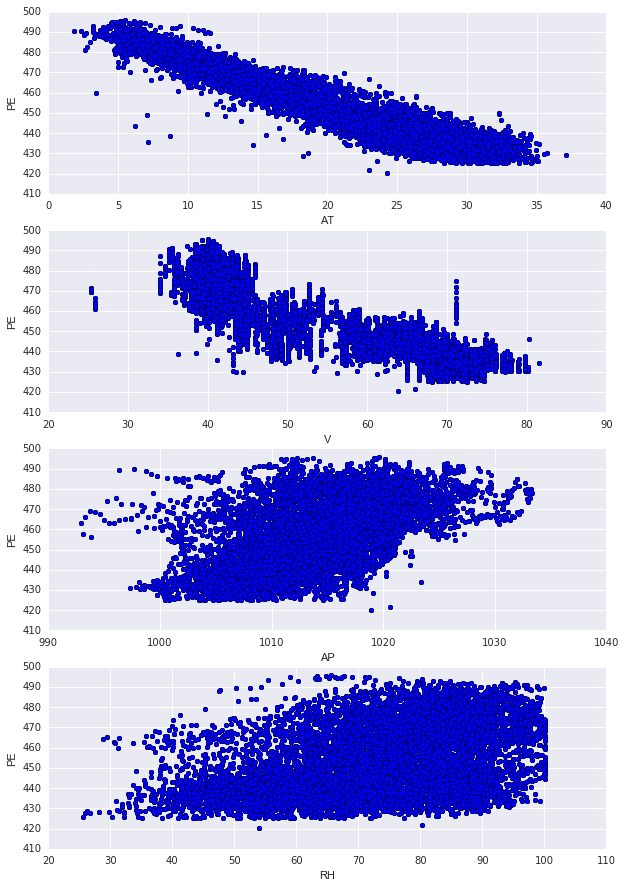

In [113]:
plt.figure(figsize=(10, 15))
for i, v in enumerate(["AT", "V", "AP", "RH"]):
    plt.subplot(4, 1, i + 1)
    plt.scatter(df[v], df["PE"])
    plt.xlabel(v)
    plt.ylabel("PE")

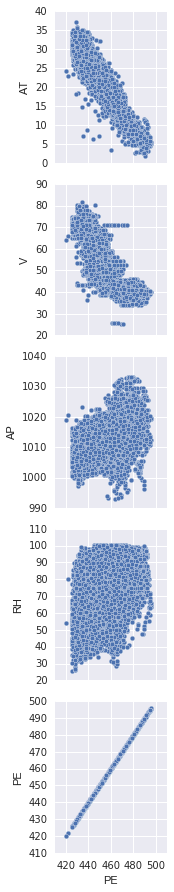

In [138]:
sns.pairplot(df, x_vars="PE", y_vars=df.columns)

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
import numpy as np

In [41]:
np.random.seed(100)
np.random.random(5)

array([ 0.54340494,  0.27836939,  0.42451759,  0.84477613,  0.00471886])

In [42]:
df.sample(10)

,AT,V,AP,RH,PE
4077,19.54,54.90,1017.15,70.37,455.86
425,21.09,46.63,1013.03,74.80,453.34
9118,29.39,69.89,1013.92,47.36,434.27
8605,19.15,39.72,1001.49,58.62,457.45
8246,21.84,58.86,1014.13,69.67,445.16
9021,15.12,52.05,1014.63,80.38,464.78
448,29.12,51.43,1005.93,60.66,437.71
5304,19.75,49.02,1009.38,92.89,446.63
4110,23.73,63.94,1010.70,87.10,441.78
3745,26.38,71.58,1011.02,80.90,434.26


In [48]:
y = df["PE"].values
type(y)

numpy.ndarray

In [53]:
X = df.iloc[:, 0].values.reshape(-1, 1)
X.shape

(47840, 1)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, random_state = 100)

In [57]:
X_train.shape, y_train.shape

((33488, 1), (33488,))

In [58]:
X_test.shape, y_test.shape

((14352, 1), (14352,))

In [60]:
14352 / (14352 + 33488)

0.3

In [61]:
from sklearn.linear_model import LinearRegression

In [63]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [64]:
lr.intercept_, lr.coef_

(497.09394395697325, array([-2.17446537]))

PE = 497.09394395697325 -2.17446537 * AT

In [66]:
y_test_pred = lr.predict(X_test)

In [68]:
output = pd.DataFrame({"actual": y_test, "prediction": y_test_pred})

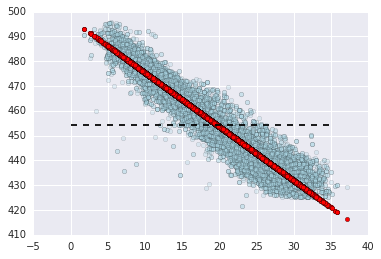

In [92]:
plt.scatter(X_test[:, 0], y_test, alpha = 0.3, c = "lightblue")
plt.scatter(X_test[:, 0], y_test_pred, c = "red")
plt.hlines([mu], xmin=0, xmax=35, linestyles = "--")


In [80]:
sorted(X_test[:, 0])[::-1][:3]

[37.109999999999999, 35.770000000000003, 35.770000000000003]

In [88]:
ssr = ((y_test_pred - y_test) ** 2).sum()
ssr

423613.9139175131

In [85]:
mu = y_train.mean()
mu

454.39998059006206

In [100]:
sst = ((y_test_pred - mu) ** 2).sum()
sst

3774789.5262649273

In [101]:
ssr / sst

0.11222186322442987

In [94]:
mssr = ssr / y_test.shape[0]
mssr

29.516019643082018

In [104]:
r2 = 1 - ssr / sst
r2
# r2 can have a max value 1, negative values of R2 means optimal model 

0.88777813677557016

In [97]:
from sklearn.metrics import mean_squared_error, r2_score

In [98]:
mean_squared_error(y_test, y_test_pred)

29.516019643082018

In [107]:
r2_score(y_test, y_test_pred) ## testing set R2

0.89821523063289865

In [105]:
ssr = ((y_test_pred - y_test) ** 2).sum()
sst = ((y_test_pred - y_test.mean()) ** 2).sum()

1 - ssr/sst

0.88777167951834757

In [106]:
r2_score(y_train, lr.predict(X_train)) #training set R2

0.89925540345319965

In [128]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.intercept_, lr.coef_)


452.138056581 [-1.97941445 -0.23293861  0.06456185 -0.15832184]


In [129]:
pd.DataFrame({"column": df.columns[:-1], "coef": lr.coef_[0]})

,coef,column
0,-1.979414,AT
1,-1.979414,V
2,-1.979414,AP
3,-1.979414,RH


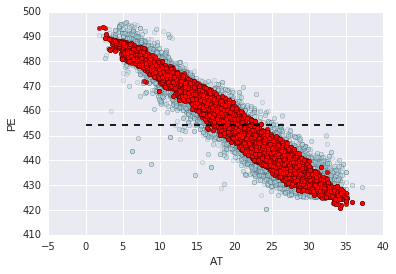

In [130]:
y_test_pred = lr.predict(X_test)
plt.scatter(X_test[:, 0], y_test, alpha = 0.3, c = "lightblue")
plt.scatter(X_test[:, 0], y_test_pred, c = "red")
plt.hlines([mu], xmin=0, xmax=35, linestyles = "--")
plt.xlabel("AT")
plt.ylabel("PE")

In [136]:
y_test_pred = lr.predict(X_test)
pd.DataFrame({"actual": y_test, "pred": y_test_pred}).sample(10)

,actual,pred
554,453.34,453.090899
5059,467.32,463.235795
11630,436.33,441.766277
9145,431.44,433.255405
10832,457.26,459.499069
6610,477.78,474.987727
10246,449.00,451.595681
3136,452.82,462.390174
5944,472.90,475.126485
4860,456.56,454.344959


In [133]:
mean_squared_error(y_test, y_test_pred)

21.727677022793074

In [126]:
y_test.shape

(14352, 1)

In [139]:
from sklearn.preprocessing import PolynomialFeatures

In [144]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
pd.DataFrame(X_train_poly).sample(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
2679,1.0,14.20,40.92,1022.26,71.71,201.6400,581.0640,14516.0920,1018.2820,1674.4464,41830.8792,2934.3732,1.045016e+06,73306.2646,5142.3241
24769,1.0,14.87,41.20,1016.27,70.51,221.1169,612.6440,15111.9349,1048.4837,1697.4400,41870.3240,2905.0120,1.032805e+06,71657.1977,4971.6601
3794,1.0,18.53,63.91,1010.26,97.80,343.3609,1184.2523,18720.1178,1812.2340,4084.4881,64565.7166,6250.3980,1.020625e+06,98803.4280,9564.8400
23243,1.0,25.20,65.59,1013.00,71.34,635.0400,1652.8680,25527.6000,1797.7680,4302.0481,66442.6700,4679.1906,1.026169e+06,72267.4200,5089.3956
25940,1.0,15.06,41.85,1016.78,88.23,226.8036,630.2610,15312.7068,1328.7438,1751.4225,42552.2430,3692.4255,1.033842e+06,89710.4994,7784.5329
14669,1.0,21.52,66.51,1015.32,72.85,463.1104,1431.2952,21849.6864,1567.7320,4423.5801,67528.9332,4845.2535,1.030875e+06,73966.0620,5307.1225
26883,1.0,14.50,44.47,1028.20,66.95,210.2500,644.8150,14908.9000,970.7750,1977.5809,45724.0540,2977.2665,1.057195e+06,68837.9900,4482.3025
28952,1.0,8.37,40.92,1021.82,86.03,70.0569,342.5004,8552.6334,720.0711,1674.4464,41812.8744,3520.3476,1.044116e+06,87907.1746,7401.1609
10795,1.0,30.68,73.67,1005.63,57.05,941.2624,2260.1956,30852.7284,1750.2940,5427.2689,74084.7621,4202.8735,1.011292e+06,57371.1915,3254.7025
9264,1.0,29.00,69.13,1001.22,52.96,841.0000,2004.7700,29035.3800,1535.8400,4778.9569,69214.3386,3661.1248,1.002441e+06,53024.6112,2804.7616


In [145]:
X_train_poly.shape

(33488, 15)

In [147]:
lr.fit(X_train_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [148]:
lr.score(poly.transform(X_test), y_test)

0.93692162258576439

In [151]:
lr.coef_

array([  0.     ,  -5.36525,  -3.37856,  15.61172,   4.21412,   0.01698,
         0.01107,   0.00267,  -0.00551,  -0.00085,   0.0029 ,   0.00008,
        -0.0076 ,  -0.00391,  -0.0018 ])

In [150]:
np.set_printoptions(suppress=True, precision=5)

In [152]:
from sklearn.linear_model import LassoCV, Lasso

In [154]:
lassocv.alpha_

8.8533008839120531e-05

In [168]:
lassocv = LassoCV(cv = 5, max_iter=10000, tol=1e-5, normalize=True)
lassocv.fit(X_train_poly, y_train)
lasso = Lasso(alpha=lassocv.alpha_, max_iter=10000, normalize=True, random_state=100)
lasso.fit(X_train_poly, y_train)
print("Features: ", lasso.coef_, "alpha: ",lassocv.alpha_
      ,  "\nR2 score: ", lasso.score(poly.transform(X_test), y_test)) 

Features:  [ 0.      -2.65805 -0.10337  0.08358  0.       0.02033  0.      -0.      -0.
 -0.      -0.      -0.00232  0.       0.      -0.     ] alpha:  8.85330088391e-05 
R2 score:  0.934970853198


In [171]:
lasso = Lasso(alpha=1e-5, max_iter=10000, normalize=True, random_state=100)
lasso.fit(X_train_poly, y_train)
print("Features: ", lasso.coef_, "alpha: "
      ,  "\nR2 score: ", lasso.score(poly.transform(X_test), y_test))

Features:  [ 0.      -2.69082 -0.24818  0.08752  0.14584  0.01844  0.00456  0.
 -0.00151 -0.00001  0.      -0.00177 -0.      -0.      -0.001  ] alpha:  
R2 score:  0.935476937984


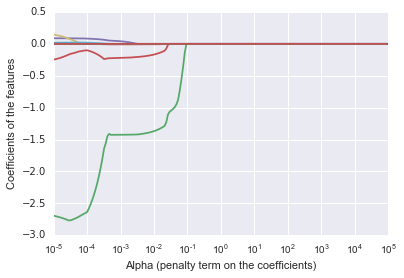

In [165]:
coefs = []
alphas = 10 ** np.linspace(-5, 5, 200)
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000, tol=1e-5,
                  normalize=True, random_state=100)
    lasso.fit(X_train_poly, y_train)
    coefs.append(lasso.coef_)

plt.plot(alphas, coefs)
plt.xscale("log")
plt.xlabel("Alpha (penalty term on the coefficients)")
plt.ylabel("Coefficients of the features")
    

# Exercise 4: Advanced Regression Problem

Use housing the data form Kaggle 

1. Apply linear regression model to predict the SalePrice. 
Use seed as 100, and build model on the nueric features alone.
report out the R2 value and MSE

2. Apply Lasso on the model on the same set of numeric features and find R2 and MSE. 
Find out which features are significant.  




In [173]:
df = pd.read_csv("../data/kaggle-house-prices/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [176]:
df_numeric = df.select_dtypes([np.float64, np.int64])
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 38 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
MasVnrArea       1452 non-null float64
BsmtFinSF1       1460 non-null int64
BsmtFinSF2       1460 non-null int64
BsmtUnfSF        1460 non-null int64
TotalBsmtSF      1460 non-null int64
1stFlrSF         1460 non-null int64
2ndFlrSF         1460 non-null int64
LowQualFinSF     1460 non-null int64
GrLivArea        1460 non-null int64
BsmtFullBath     1460 non-null int64
BsmtHalfBath     1460 non-null int64
FullBath         1460 non-null int64
HalfBath         1460 non-null int64
BedroomAbvGr     1460 non-null int64
KitchenAbvGr     1460 non-null int64
TotRmsAbvGrd     1460 non-null int64
F

In [192]:
df_numeric = df_numeric.fillna(df_numeric.median())

In [194]:
if "Id" in df_numeric.columns:
    del df_numeric["Id"]

In [367]:
X, y = df_numeric.iloc[:, :-1],  df_numeric.iloc[:, -1]

In [368]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    test_size = 0.3, random_state = 123)

In [369]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.84089024129623291

In [372]:
from sklearn.model_selection import cross_val_score, KFold
scores = cross_val_score(cv=5, estimator=LinearRegression(), 
                         scoring= metrics.make_scorer(metrics.median_absolute_error), 
                         X=X_train, y=y_train)
scores.mean()

16752.756460072898

In [230]:
lassocv = LassoCV(cv = 5, max_iter=10000, normalize=True, tol=1e-6)
lassocv.fit(X_train, y_train)
print("Features: ", lasso.coef_, "alpha: ",lassocv.alpha_
      ,  "\nR2 score: ", lassocv.score(X_test, y_test))

Features:  [  -1.03807   -0.         0.2543     0.         0.       342.60051
  125.76898   36.30842   10.16317   -0.         0.        33.17161
    6.11612    7.93248   -0.        55.70217    0.        -0.         0.
    0.        -0.        -0.         0.         0.         0.         0.
   67.58039   34.19014    0.        -0.         0.         0.        -0.
   -5.23374    0.        -0.     ] alpha:  131.676891221 
R2 score:  0.813145915129


In [305]:
lassocv.coef_, lassocv.n_iter_

(array([   -70.75258,      0.     ,      0.12191,  20656.13644,
             0.     ,    150.37845,    204.31567,     16.6034 ,
            11.0479 ,      0.     ,     -0.     ,      6.32843,
             9.67781,      0.     ,     -0.     ,     38.4906 ,
          2380.93555,      0.     ,      0.     ,      0.     ,
            -0.     ,     -0.     ,      0.     ,   4522.7387 ,
             0.     ,  11794.81555,      0.     ,     12.97316,
             0.     ,     -0.     ,      0.     ,      0.     ,
            -0.     ,     -0.     ,      0.     ,     -0.     ]), 45)

In [252]:
coefficients = pd.DataFrame({"field": df_numeric.columns[:-1], "coefficient": lassocv.coef_})
significant_fields = list(coefficients[coefficients.coefficient != 0].field)
significant_fields

['MSSubClass',
 'LotArea',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'Fireplaces',
 'GarageCars',
 'WoodDeckSF']

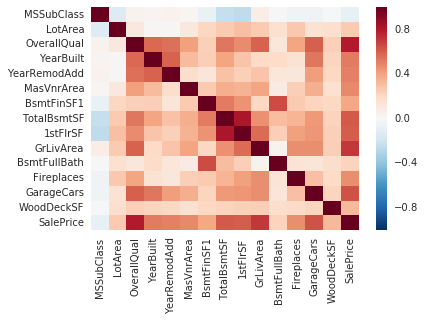

In [253]:
significant_fields.append("SalePrice")
df_mini = df[significant_fields]
sns.heatmap(df_mini.corr())

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


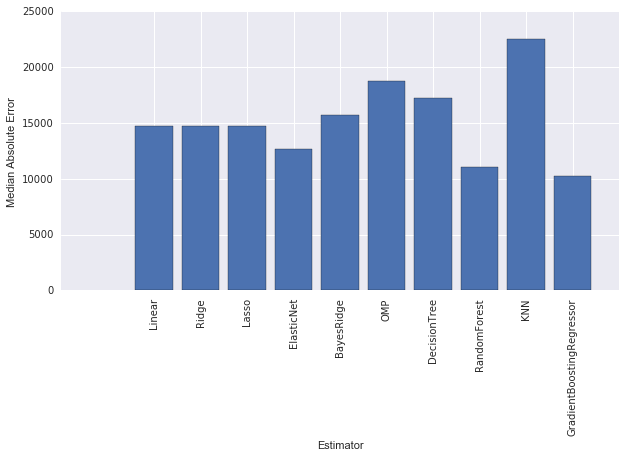

In [304]:
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn import ensemble
from sklearn import neighbors

rs = 1
ests = [ 
    linear_model.LinearRegression(), 
    linear_model.Ridge(),    
    linear_model.Lasso(), 
    linear_model.ElasticNet(),
    linear_model.BayesianRidge(),
    linear_model.OrthogonalMatchingPursuit(),
    tree.DecisionTreeRegressor(max_depth=10),
    ensemble.RandomForestRegressor(),
    neighbors.KNeighborsRegressor(n_neighbors=5),
    ensemble.GradientBoostingRegressor(n_estimators=300, max_depth=4, learning_rate=0.01,loss="ls")
]

ests_labels = ['Linear', 
               'Ridge', 
               'Lasso',
               'ElasticNet',
               'BayesRidge',
               'OMP',
               'DecisionTree',
               'RandomForest',
               'KNN',
               'GradientBoostingRegressor']

errvals = []

for e in ests:
    e.fit(X_train, y_train)
    err = metrics.median_absolute_error(y_test, e.predict(X_test))
    errvals.append(err)


pos = range(len(errvals))
plt.figure(figsize=(10,5))
plt.bar(pos, errvals, align='center')
plt.xticks(pos, ests_labels, rotation = 90)
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

    

In [334]:
from sklearn.model_selection import GridSearchCV

tuned_parameters = {
    "n_estimators": [ 100, 200, 300 ],
    "max_depth" : [ 4 , 6, 10],
    "learning_rate": [ 0.001, 0.01 ],
    "min_samples_split" : [2, 3],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv = 5, param_grid=tuned_parameters, scoring='neg_median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_
err = metrics.median_absolute_error(y_test, best.predict(X_test))
features = pd.DataFrame({"importance": best.feature_importances_, "feature": df_numeric.columns[:-1]})
features.sort_values("importance", ascending=False)

,feature,importance
32,PoolArea,0.000319
30,3SsnPorch,0.001443
14,LowQualFinSF,0.002590
33,MiscVal,0.002866
17,BsmtHalfBath,0.003418
21,KitchenAbvGr,0.005081
19,HalfBath,0.005370
16,BsmtFullBath,0.006458
9,BsmtFinSF2,0.008288
29,EnclosedPorch,0.009122


In [336]:
best.score(X_test, y_test)

0.82236157592788239

In [303]:
from sklearn.feature_selection import f_regression, SelectKBest

kbest = SelectKBest(f_regression)
kbest.fit(X_train, y_train)
features = pd.DataFrame({"score": kbest.scores_, "pval": kbest.pvalues_, "feature": df_numeric.columns[:-1]})
features.sort_values("score", ascending=False)

,feature,pval,score
3,OverallQual,1.352934e-219,1701.522419
15,GrLivArea,3.552373e-147,943.022095
25,GarageCars,3.679569e-115,679.135784
12,1stFlrSF,1.783492e-109,636.139624
26,GarageArea,3.004206e-108,627.008763
11,TotalBsmtSF,5.958884e-108,624.802014
18,FullBath,5.987983e-85,462.841012
5,YearBuilt,9.641869e-74,389.845615
22,TotRmsAbvGrd,3.009689e-72,380.389917
6,YearRemodAdd,2.023751e-62,319.780784


In [342]:
df_categorical = df.select_dtypes(exclude=[np.float64, np.int64])
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 43 columns):
MSZoning         1460 non-null object
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-null object
MasVnrType       1452 non-null object
ExterQual        1460 non-null object
ExterCond        1460 non-null object
Foundation       1460 non-null object
BsmtQual         1423 non-null object
BsmtCond         1423 non-null object
BsmtExposure     1422

In [379]:
categorical_columns = df.select_dtypes(exclude=[np.float64, np.int64]).columns
df_clean = pd.get_dummies(df, drop_first=True, 
               prefix=categorical_columns, columns= categorical_columns, 
               dummy_na=False)
del df_clean["Id"]
df_clean = df_clean.fillna(df_clean.median())
df_clean.sample(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1081,20,75.0,7500,5,5,1963,1963,0.0,824,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
640,120,62.0,12677,8,5,2003,2004,472.0,1218,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
346,20,69.0,12772,6,8,1960,1998,0.0,498,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
688,20,60.0,8089,8,6,2007,2007,0.0,945,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
320,60,111.0,16259,9,5,2006,2006,370.0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
472,180,35.0,3675,6,5,2005,2005,80.0,459,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
844,50,100.0,12665,5,8,1915,1950,0.0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1155,20,90.0,10768,5,8,1976,2004,0.0,1157,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
618,20,90.0,11694,9,5,2007,2007,452.0,48,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1302,60,92.0,10120,8,5,1994,1994,391.0,740,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [380]:
y = df_clean.SalePrice
if "SalePrice" in df_clean.columns: 
    del df_clean["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(df_clean.values, y, random_state = 100)

In [381]:
lassocv.fit(X_train, y_train)
y_test_pred = lassocv.predict(X_test)
metrics.median_absolute_error(y_test, y_test_pred), r

11856.627388723427

In [364]:
lassocv.coef_, lassocv.alpha_

(array([    -89.22734,      62.01816,       0.35272,    9610.61595,
           4415.62284,     274.44517,     156.56264,      20.10729,
             14.95369,       0.     ,      -0.     ,      18.98548,
              0.     ,       0.     ,     -40.18821,      63.04727,
           2407.17894,      -0.     ,       0.     ,       0.     ,
          -2776.08912,  -15141.3543 ,       0.     ,    2581.83585,
             55.68917,    2054.18024,      15.60723,       1.68698,
              9.7677 ,      -0.     ,       0.     ,       0.     ,
             56.39119,      -0.     ,      -0.     ,      -0.     ,
              0.     ,      -0.     ,       0.     ,   -1734.82905,
              0.     ,    8405.01829,       0.     ,      -0.     ,
            423.01765,       0.     ,      -0.     ,      -0.     ,
              0.     ,       0.     ,      -0.     ,       0.     ,
              0.     ,      -0.     ,       0.     ,    7608.83197,
           -118.41199,      -0.     ,      -0.  

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


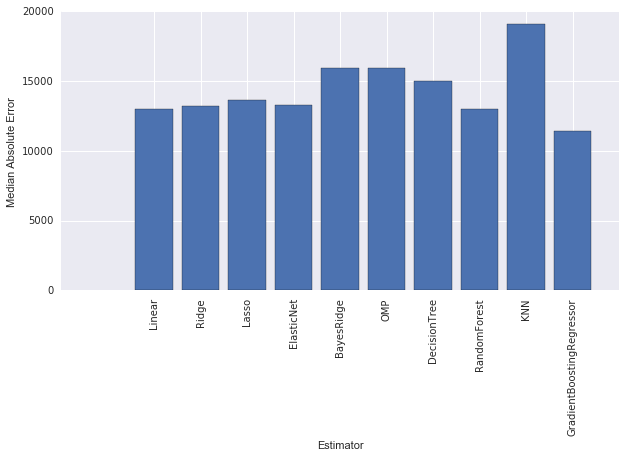

In [365]:
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn import ensemble
from sklearn import neighbors

rs = 1
ests = [ 
    linear_model.LinearRegression(), 
    linear_model.Ridge(),    
    linear_model.Lasso(), 
    linear_model.ElasticNet(),
    linear_model.BayesianRidge(),
    linear_model.OrthogonalMatchingPursuit(),
    tree.DecisionTreeRegressor(max_depth=10),
    ensemble.RandomForestRegressor(),
    neighbors.KNeighborsRegressor(n_neighbors=5),
    ensemble.GradientBoostingRegressor(n_estimators=300, max_depth=4, learning_rate=0.01,loss="ls")
]

ests_labels = ['Linear', 
               'Ridge', 
               'Lasso',
               'ElasticNet',
               'BayesRidge',
               'OMP',
               'DecisionTree',
               'RandomForest',
               'KNN',
               'GradientBoostingRegressor']

errvals = []

for e in ests:
    e.fit(X_train, y_train)
    err = metrics.median_absolute_error(y_test, e.predict(X_test))
    errvals.append(err)


pos = range(len(errvals))
plt.figure(figsize=(10,5))
plt.bar(pos, errvals, align='center')
plt.xticks(pos, ests_labels, rotation = 90)
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')